# Streamlining workflows with pipelines

Pipeline class of scikit-learn allows us to fit a model including an arbitrary number
of transformation steps and apply it to make predictions about new data.

### Loading the Breast Cancer Wisconsin dataset

In [1]:
import pandas as pd
#read data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.preprocessing import LabelEncoder

#Separate feature and label columns from dataset
X, y = df.loc[:, 2:].values, df.loc[:, 1].values

#Convert class labels to integer
le = LabelEncoder()
y = le.fit_transform(y)

le.transform(['M', 'B'])

array([1, 0])

In [7]:
from sklearn.cross_validation import train_test_split

#split data into training set (80% of data) and testing set(20% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 1)

### Combining transformers and estimators in a pipeline

The Pipeline object takes a list of tuples as input, where the first value in each tuple
is an arbitrary identifier string that we can use to access the individual elements in
the pipeline and the second element in every
tuple is a scikit-learn transformer or estimator.

The intermediate steps in a pipeline constitute scikit-learn transformers, and the
last step is an estimator. 

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#combine scaler, PCA and LR into a single pipe
pipe_lr = Pipeline([('scl', StandardScaler()), 
                   ('pca', PCA(n_components = 2)), 
                   ('clf', LogisticRegression(random_state = 1))])

#fit training data onto the pipe component
pipe_lr.fit(X_train, y_train)

#compute accuracy of the resulting model on test dataset
print ('Test accuracy: %.3f' %pipe_lr.score(X_test, y_test))

Test accuracy: 0.947


# Using k-fold cross-validation to assess model performance

A model can
either suffer from underfitting (high bias) if the model is too simple, or it can overfit
the training data (high variance) if the model is too complex for the underlying
training data. Useful cross-validation
techniques like holdout cross-validation and k-fold cross-validation can help us
obtain reliable estimates of the model's generalization error, that is, how well the
model performs on unseen data.

### The holdout method

This process of model selection involves tuning and
comparing different parameter settings to further improve the performance for
making predictions on unseen data. 

A better way of using the holdout method for model selection is to separate the data
into three parts: a training set, a validation set, and a test set. The training set is used
to fit the different models, and the performance on the validation set is then used
for the model selection. Once we are satisfied with the tuning of parameter values, we
estimate the models' generalization error on the test dataset. 

A disadvantage of the holdout method is that the performance estimate is
sensitive to how we partition the training set into the training and validation
subsets; the estimate will vary for different samples of the data.

### K-fold cross-validation

In k-fold cross-validation, we randomly split the training dataset into k folds without
replacement, where k −1 folds are used for the model training and one fold is used
for testing. This procedure is repeated k times so that we obtain k models and
performance estimates.

We then calculate the average performance of the models based on the different,
independent folds to obtain a performance estimate that is less sensitive to the
subpartitioning of the training data compared to the holdout method. Once we
have found satisfactory hyperparameter values, we can retrain the model on the
complete training set and obtain a final performance estimate using the independent
test set.

Since k-fold cross-validation is a resampling technique without replacement, the
advantage of this approach is that each sample point will be part of a training
and test dataset exactly once, which yields a lower-variance estimate of the model
performance than the holdout method. 

The standard value for k in k-fold cross-validation is 10, which is typically a
reasonable choice for most applications. However, if we are working with relatively
small training sets, it can be useful to increase the number of folds. If we increase
the value of k, more training data will be used in each iteration, which results in
a lower bias towards estimating the generalization performance by averaging
the individual model estimates. However, large values of k will also increase the
runtime of the cross-validation algorithm and yield estimates with higher variance
since the training folds will be more similar to each other. On the other hand, if we
are working with large datasets, we can choose a smaller value for k, for example,
k = 5 , and still obtain an accurate estimate of the average performance of the model.

A slight improvement over the standard k-fold cross-validation approach is
stratified k-fold cross-validation, which can yield better bias and variance estimates,
especially in cases of unequal class proportions. In stratified
cross-validation, the class proportions are preserved in each fold to ensure that each
fold is representative of the class proportions in the training dataset.

In [11]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y = y_train, n_folds = 10, random_state = 1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print ('Fold: %s, Class dist: %s, Accuracy: %.3f' %(k + 1, 
                        np.bincount(y_train[train]), score))
print()
print ('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold: 1, Class dist: [256 153], Accuracy: 0.891
Fold: 2, Class dist: [256 153], Accuracy: 0.978
Fold: 3, Class dist: [256 153], Accuracy: 0.978
Fold: 4, Class dist: [256 153], Accuracy: 0.913
Fold: 5, Class dist: [256 153], Accuracy: 0.935
Fold: 6, Class dist: [257 153], Accuracy: 0.978
Fold: 7, Class dist: [257 153], Accuracy: 0.933
Fold: 8, Class dist: [257 153], Accuracy: 0.956
Fold: 9, Class dist: [257 153], Accuracy: 0.978
Fold: 10, Class dist: [257 153], Accuracy: 0.956

CV accuracy: 0.950 +/- 0.029


scikit-learn also implements a k-fold cross-validation
scorer, which allows us to evaluate our model using stratified k-fold
cross-validation more efficiently. 

By setting n_jobs=-1 in cross_val_score function, we can use all available
CPUs on our machine to do the computation in parallel.

In [13]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator = pipe_lr, X = X_train, 
                        y = y_train, cv = 10, n_jobs = 1)
print ('CV accuracy scores: %s' %scores)
print ('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use insp

# Debugging algorithms with learning and validation curves

### Diagnosing bias and variance problems with learning curves

By plotting the
model training and validation accuracies as functions of the training set size, we can
easily detect whether the model suffers from high variance or high bias, and whether
the collection of more data could help to address this problem. 

Common ways to address underfitting issue are to increase the number of
parameters of the model, for example, by collecting or constructing additional
features, or by decreasing the degree of regularization. 

To address problem of overfitting, we can collect
more training data or reduce the complexity of the model, for example, by increasing
the regularization parameter; for unregularized models, it can also help to decrease
the number of features via feature selection or feature extraction. 

When the
training data is extremely noisy or the model is already very close to optimal, collecting additional 
data points for training dataset may not help.

/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use insp

NameError: name 'ylim' is not defined

/Users/admin/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


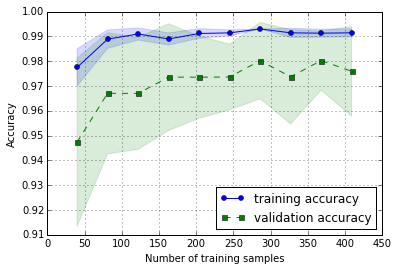

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()), 
        ('clf', LogisticRegression(penalty = 'l2',
                                   random_state = 0)),                  
    ])
train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr, X = X_train, y = y_train, 
              train_sizes = np.linspace(0.1, 1.0, 10), cv = 10, 
               n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', 
        markersize = 5, label = 'training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, 
               train_mean - train_std, alpha = 0.15, color = 'blue')
plt.plot(train_sizes, test_mean, color = 'green', marker = 's', 
        markersize = 5, linestyle = '--',
        label = 'validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, 
               test_mean - test_std, alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
ylim([0.8, 1.0])
plt.show()

### Addressing overfitting and underfitting with validation curves

Validation curves are related to
learning curves, but instead of plotting the training and test accuracies as functions
of the sample size, we vary the values of the model parameters, for example, the
inverse regularization parameter C in logistic regression.

Similar to the learning_curve function, the validation_curve function uses
stratified k-fold cross-validation by default to estimate the performance of the model
if we are using algorithms for classification

/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use insp

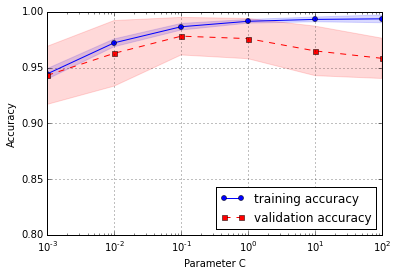

In [23]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator = pipe_lr, 
                                            X = X_train, y = y_train, 
                                            param_name = 'clf__C', 
                                            param_range = param_range, 
                                            cv = 10)
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

#plot mean of train scores over range of selected params
plt.plot(param_range, train_mean, color = 'blue', marker = 'o', 
        markersize = 5, label = 'training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std,
               alpha = 0.15, color = 'blue')

#plot mean of test scores over range of selected params
plt.plot(param_range, test_mean, color = 'red', linestyle = '--', marker = 's', 
        markersize = 5, label = 'validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, 
               alpha = 0.15, color = 'red')
plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

# Fine-tuning machine learning models via grid search

Grid search can further help to improve the performance of a model by finding the optimal combination of
hyperparameter values.

### Tuning hyperparameters via grid search

In [27]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

#create a pipeline to scale training dataset and then run SVM model 
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state = 1))
                    ])

#create range of possible values of C and gamma that would be used for CV
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

#create a grid of all possible combinations of hyperparam values that we need to tune
param_grid = [{'clf__C': param_range,'clf__kernel': ['linear']},
              {'clf__C': param_range, 'clf__kernel': ['rbf'], 'clf__gamma': param_range}]

#train model using various hyperparams and compute accuracy of resulting model
gs = GridSearchCV(estimator = pipe_svc, 
                 param_grid = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)

#fit model on training dataset 
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [28]:
#find best model and fit training set on the best model
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print ('Test accuracy: %.3f' %clf.score(X_test, y_test))

Test accuracy: 0.965


Although grid search is a powerful approach for finding the optimal set of
parameters, the evaluation of all possible parameter combinations is also
computationally very expensive. An alternative approach to sampling
different parameter combinations using scikit-learn is randomized search.
Using the RandomizedSearchCV class in scikit-learn, we can draw
random parameter combinations from sampling distributions with a
specified budget. More details and examples for its usage can be found
at http://scikit-learn.org/stable/modules/grid_search.
html#randomized-parameter-optimization.

### Algorithm selection with nested cross-validation

In nested cross-validation, we have an outer k-fold cross-validation loop to split the
data into training and test folds, and an inner loop is used to select the model using
k-fold cross-validation on the training fold. After model selection, the test fold is then
used to evaluate the model performance. 

In [30]:
gs = GridSearchCV(estimator = pipe_svc, 
                 param_grid = param_grid, scoring = 'accuracy', 
                 cv = 10, n_jobs = -1)
scores = cross_val_score(gs, X, y, scoring = 'accuracy', cv = 5)
print ('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


In [32]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}]
gs = GridSearchCV(estimator = DecisionTreeClassifier(), 
                 param_grid = param_grid, 
                 cv = 10, scoring = 'accuracy')
scores = cross_val_score(gs, X, y, scoring = 'accuracy', cv = 5)
print ('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.020


# Looking at different performance evaluation metrics

### Reading a confusion matrix

The confusion matrix is simply a square matrix that reports the counts of the true
positive, true negative, false positive, and false negative predictions of a classifier

In [33]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print (conf_mat)

[[71  1]
 [ 2 40]]


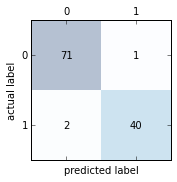

In [36]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x = j, y = i, s = conf_mat[i, j], 
               va = 'center', ha = 'center')
plt.xlabel('predicted label')
plt.ylabel('actual label')
plt.show()

### Optimizing the precision and recall of a classification model

Both the prediction error (ERR) and accuracy (ACC) provide general information
about how many samples are misclassified. The error can be understood as the
sum of all false predictions divided by the number of total predications, and the
accuracy is calculated as the sum of correct predictions divided by the total number
of predictions, respectively. 

The true positive rate (TPR) and false positive rate (FPR) are performance metrics
that are especially useful for imbalanced class problems.

Precision (PRE) and recall (REC) are performance metrics that are related to those
true positive and true negative rates.

In practice, often a combination of precision and recall is used, called F1-score

A complete list of the different values that
are accepted by the scoring parameter can be found at http://scikit-learn.org/
stable/modules/model_evaluation.html. 

In [38]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print ('Precision: %.3f' %precision_score(y_true = y_test, y_pred = y_pred))
print ('Recall: %.3f' %recall_score(y_true = y_test, y_pred = y_pred))
print ('F1 score: %.3f' %f1_score(y_true = y_test, y_pred = y_pred))

Precision: 0.976
Recall: 0.952
F1 score: 0.964


The positive class in scikit-learn is the class that is labeled as class 1.If we want to specify a different positive label, we can construct our own scorer via
the make_scorer function

In [39]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, 
                 scoring = scorer, cv = 10)

### Plotting a receiver operating characteristic

Receiver operator characteristic (ROC) graphs are useful tools for selecting models
for classification based on their performance with respect to the false positive and
true positive rates. The diagonal of an ROC graph can be interpreted as random guessing,
and classification models that fall below the diagonal are considered as worse than
random guessing. A perfect classifier would fall into the top-left corner of the graph
with a true positive rate of 1 and a false positive rate of 0. Based on the ROC curve,
we can then compute the so-called area under the curve (AUC) to characterize the
performance of a classification model.

Similar to ROC curves, we can compute precision-recall curves for the
different probability thresholds of a classifier. A function for plotting
those precision-recall curves is also implemented in scikit-learn and is
documented at http://scikit-learn.org/stable/modules/
generated/sklearn.metrics.precision_recall_curve.html.

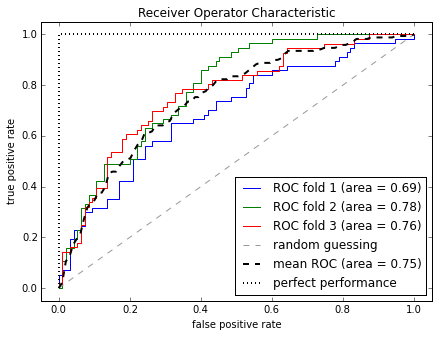

In [44]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
X_train2 = X_train[: , [4, 14]]
cv = StratifiedKFold(y_train, n_folds = 3, random_state = 1)
fig = plt.figure(figsize = (7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label = 1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc =  auc(fpr, tpr)
    plt.plot(fpr, tpr, lw = 1, label = 'ROC fold %d (area = %.2f)' %(i+1, roc_auc))
plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label = 'mean ROC (area = %0.2f)' % mean_auc, lw = 2)
plt.plot([0, 0, 1], [0, 1, 1], lw = 2, linestyle = ':', color = 'black', 
         label = 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = 'lower right')
plt.show()

In [46]:
#run pipelined svm on new train data with only two features and make predictions on test dataset
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print ('ROC AUC: %.3f' %roc_auc_score(y_true = y_test, y_score = y_pred2))
print ('Accuracy: %.3f' %accuracy_score(y_true = y_test, y_pred = y_pred2))


ROC AUC: 0.671
Accuracy: 0.728


### The scoring metrics for multiclass classification

scikit-learn also implements macro and micro
averaging methods to extend those scoring metrics to multiclass problems via
One vs. All (OvA) classification. The micro-average is calculated from the individual
true positives, true negatives, false positives, and false negatives of the system.The macro-average is simply calculated as the average scores of the different systems. 

In [50]:
from sklearn.metrics import make_scorer
pre_scorer = make_scorer(score_func = precision_score, pos_label = 1, 
                        greater_is_better = True, average = 'micro')
macro_scorer = make_scorer(score_func = precision_score, pos_label = 1, 
                          greater_is_better = True)